In [2]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PlotFuncs import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from scipy.stats import norm
import pandas

import cmocean

# Load shards
df = pandas.read_csv('../data/FitShards_red.csv')
names = df.group_id
nshards = size(names)
velocities = zeros(shape=(nshards,3))
dispersions = zeros(shape=(nshards,3))
velocities[0:(nshards),0] = df.vx # stream velocities
velocities[0:(nshards),1] = df.vy
velocities[0:(nshards),2] = df.vz
dispersions[0:(nshards),0] = df.sigx # dispersion tensors
dispersions[0:(nshards),1] = df.sigy
dispersions[0:(nshards),2] = df.sigz
pops = df.population
Psun = df.Psun
weights = ShardsWeights(names,pops,Psun)

# Halo params
HaloModel = SHMpp
v0 = HaloModel.RotationSpeed
v_esc = HaloModel.EscapeSpeed
sig_beta = HaloModel.SausageDispersionTensor
sig_iso = array([1.0,1.0,1.0])*v0/sqrt(2.0)
day = 67.0 

In [3]:
n = 600
nn = int(n*n/2)
PH, TH = meshgrid(linspace(0, 2*pi, n), linspace(-pi/2, pi/2, int(n/2)))
X = cos(PH)*cos(TH)
Y = -sin(PH)*cos(TH)
Z = -sin(TH)
ii = 0
q = zeros(shape=(nn,3))
for i in range(0,int(n/2)):
    for j in range(0,n):
        q[ii,:] = array([X[i,j],Y[i,j],Z[i,j]])
        ii = ii+1
        
def convertmap(fv3D):
    fv_map = zeros(shape=(int(n/2),n))
    ii = 0
    for i in range(0,int(n/2)):
        for j in range(0,n):
            fv_map[i,j] = fv3D[ii]
            ii = ii+1
    fv_map = flipud(fv_map)
    return fv_map

# v binning
nv = 1000
v_vals = linspace(0.1,600,nv)

# Smooth
fv3D_Saus = zeros(shape=nn)
fv3D_Iso = zeros(shape=nn)
for j in range(0,nv):
    fv3D_Iso += v_vals[j]*VelocityDist_Triaxial(-v_vals[j]*q,day,sig_iso)
    fv3D_Saus += v_vals[j]*VelocityDist_Triaxial(-v_vals[j]*q,day,sig_beta)
fv_map_Saus = convertmap(fv3D_Saus)
fv_map_Iso = convertmap(fv3D_Iso)
    
# # Shards
fv_map_shards = zeros(shape=(int(n/2),n,nshards))
for isub in range(0,nshards):
    v_str = velocities[isub,:]
    x_str = v_str/sqrt(sum(v_str**2.0))
    sig_s = dispersions[isub,:]
    fv3D = zeros(shape=nn)
    for j in range(0,nv):
        fv3D += v_vals[j]*weights[isub]*VelocityDist_Triaxial(-v_vals[j]*q,day,sig_s,v_shift=v_str)
    print(isub)
    fv_map_shards[:,:,isub] = convertmap(fv3D)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
/Users/ciaranohare/Work/Zaragoza/HaloSpin/code/HaloFuncs.py:53: RuntimeWarning: invalid value encountered in double_scalars
  *erfi(v_esc/(sqrt(2)*sigr)*sqrt(beta/(1-beta)))

29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58


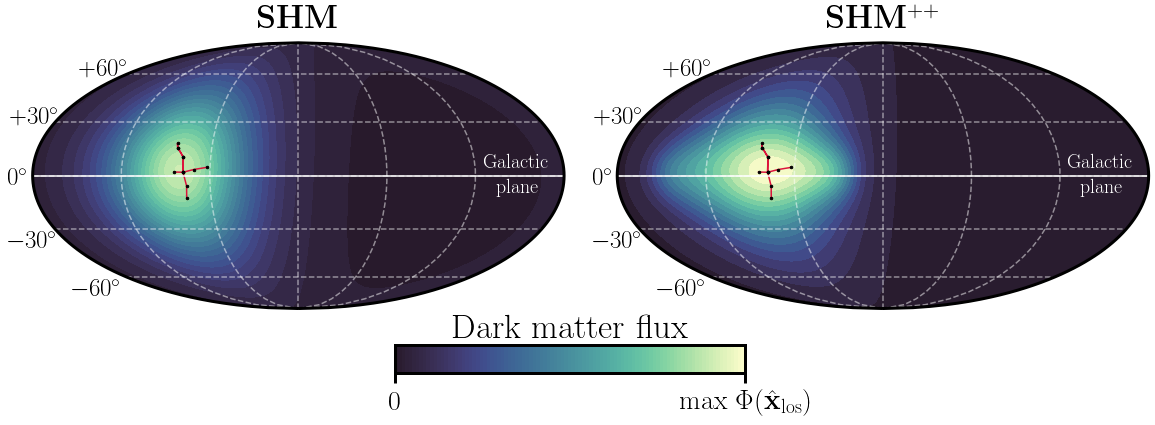

In [11]:
#####

eta = 0.2
xi = 0.1
#fv0 = (1-eta-0.0001)*fv_map_Iso + eta*fv_map_Saus + 0.0001*sum(fv_map_shards,2)
#fv_tot = (1-eta-xi)*fv_map_Iso + eta*fv_map_Saus + xi*sum(fv_map_shards,2)

fv0 = fv_map_Iso
fv_tot = (1-0.3)*fv_map_Iso+0.3*fv_map_Saus
cmax = amax(fv_tot)
cmin = amin(fv0)
cmap = cmocean.cm.deep_r
nlevels = 24
tfs = 25

#####

fig, axarr = plt.subplots(1, 2,figsize=(20,10))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)



ax = plt.subplot(gs[0],projection=ccrs.Mollweide())
MollweideMap1(ax,TH,PH,fv0,cmin,cmax,nlevels,cmap,tfs,PlotCygnus=True,gridlinecolor='w',GalacticPlane=True)
#plt.title(r'{\bf SHM}$^{++}$',fontsize=32,y=1.03)
plt.title(r'{\bf SHM}',fontsize=32,y=1.03)


ax = plt.subplot(gs[1],projection=ccrs.Mollweide())
MollweideMap1(ax,TH,PH,fv_tot,cmin,cmax,nlevels,cmap,tfs,PlotCygnus=True,gridlinecolor='w',GalacticPlane=True)
#plt.title(r'{\bf SHM}$^{++}$+{\bf 10\%} {\bf Shards}',fontsize=32,y=1.03)
plt.title(r'{\bf SHM}$^{++}$',fontsize=32,y=1.03)


####

# # Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbaxes = inset_axes(ax, width="50%", height="7%", bbox_to_anchor=[200, -200, 700, 400]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,100),orientation='horizontal')
f = plt.gcf().get_children()
cbar = f[3]
cbar.set_xticklabels(['0', r'max $\Phi(\hat{\mathbf{x}}_{\rm los})$'])  # vertically oriented colorbar
cbar.tick_params(labelsize=28) 
cbar.tick_params(which='major',direction='out',width=3,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=3,length=7,right=True,top=False)
cbar.set_title(r'Dark matter flux',fontsize=35)





plt.show()
pltname = 'SausFlux'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

In [8]:
fv_tot

array([[0.00011279, 0.00011279, 0.00011279, ..., 0.00011279, 0.00011279,
        0.00011279],
       [0.00011316, 0.00011313, 0.00011311, ..., 0.0001132 , 0.00011318,
        0.00011316],
       [0.00011352, 0.00011348, 0.00011341, ..., 0.00011361, 0.00011357,
        0.00011352],
       ...,
       [0.00013965, 0.00013959, 0.00013951, ..., 0.00013977, 0.00013971,
        0.00013965],
       [0.00013918, 0.00013915, 0.00013913, ..., 0.00013924, 0.00013921,
        0.00013918],
       [0.00013872, 0.00013872, 0.00013872, ..., 0.00013872, 0.00013872,
        0.00013872]])

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



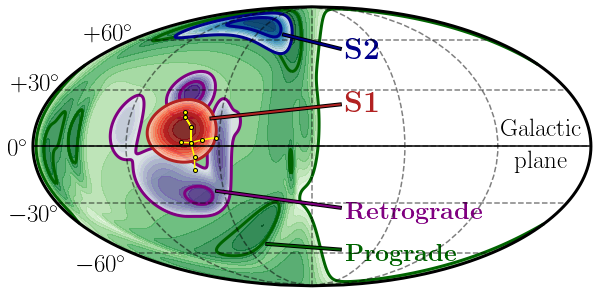

In [139]:
fig, axarr = plt.subplots(1, 1,figsize=(10,10))
gs = gridspec.GridSpec(1, 1)


levels = [-4,-1,0]
cols = cmocean.cm.phase(linspace(0,1,6))
cols = ['FireBrick','DarkBlue','Purple','DarkGreen','Blue']
cmaps = [cm.Reds,cm.Blues,cm.Purples,cm.Greens,cm.BuPu]
vmins = [-4.5,-4,-4.5,-4.5,-4.5]
vmaxs = [0.0,0.0,0.0,0.0,0.0]
alph = 0.8

idi = ['S1','S2','R','Ca','N']
zo = 5
for i in range(0,5): 
    mask1 = zeros(shape=nshards)==1
    for j in range(0,nshards):
        mask1[j] = names[j].startswith(idi[i])
    L = log(sum(fv_map_shards[:,:,mask1],axis=2))
    L = L-amax(L)
    ax = plt.subplot(gs[0],projection=ccrs.Mollweide())
    ax.contour(rad2deg(PH), rad2deg(TH),L,levels=levels,transform=ccrs.PlateCarree(),colors=cols[i],linestyles='-',linewidths=3,zorder=zo+1)
    L[L<-4] = nan
    ax.contourf(rad2deg(PH), rad2deg(TH),L,levels=10,vmin=vmins[i],vmax=vmaxs[i],transform=ccrs.PlateCarree(),cmap=cmaps[i],linestyles='none',alpha=alph,zorder=zo)
    zo -= 2
    
    

gridlinecolor='k'
gl = ax.gridlines(color=gridlinecolor,linewidth=1.5, linestyle='--',alpha=0.5,zorder=10)
gl.ylocator = mticker.FixedLocator([-90,-60, -30, 0, 30, 60,90])
ax.outline_patch.set_linewidth(3)

tx = array([r'$-60^\circ$',r'$-30^\circ$',r'$0^\circ$',r'$+30^\circ$',r'$+60^\circ$']) 
xtx = array([0.17,0.05,-0.01,0.05,0.18])
ytx = array([0.08,0.26,0.49,0.72,0.9])
    
for i in range(0,size(xtx)):
    plt.text(xtx[i],ytx[i],tx[i],transform=ax.transAxes,horizontalalignment='right',verticalalignment='center',fontsize=tfs)


ax.plot(-cyg[0:4,0],cyg[0:4,1],'-',color='yellow',transform=ccrs.PlateCarree(),zorder=10)
ax.plot(-cyg[4:,0],cyg[4:,1],'-',color='yellow',transform=ccrs.PlateCarree(),zorder=10)
ax.plot(-cyg[:,0],cyg[:,1],'.',color='yellow',markeredgecolor='k',ms=8,transform=ccrs.PlateCarree(),zorder=10)

ax.plot([-181,181],[0,0],'-',color=gridlinecolor,lw=1.5,transform=ccrs.PlateCarree(),zorder=10)
ax.text(122,5,'Galactic',color=gridlinecolor,transform=ccrs.PlateCarree(),fontsize=int(tfs),zorder=10)
ax.text(132,-12,'plane',color=gridlinecolor,transform=ccrs.PlateCarree(),fontsize=int(tfs),zorder=10)

plt.plot([0.32,0.55],[0.6,0.65],'-',color='k',transform=ax.transAxes,lw=4,zorder=10)
plt.plot([0.32,0.55],[0.6,0.65],'-',color=cols[0],transform=ax.transAxes,lw=2,zorder=10)
plt.text(0.55+0.01,0.65-0.03,r'{\bf S1}',color=cols[0],fontsize=30,transform=ax.transAxes)

plt.plot([0.45,0.55],[0.9,0.85],'-',color='k',transform=ax.transAxes,lw=4,zorder=10)
plt.plot([0.45,0.55],[0.9,0.85],'-',color=cols[1],transform=ax.transAxes,lw=2,zorder=10)
plt.text(0.55+0.01,0.85-0.04,r'{\bf S2}',color=cols[1],fontsize=30,transform=ax.transAxes)

plt.plot([0.33,0.55],[0.34,0.28],'-',color='k',transform=ax.transAxes,lw=4,zorder=10)
plt.plot([0.33,0.55],[0.34,0.28],'-',color=cols[2],transform=ax.transAxes,lw=2,zorder=10)
plt.text(0.55+0.01,0.29-0.05,r'{\bf Retrograde}',color=cols[2],fontsize=25,transform=ax.transAxes)

plt.plot([0.42,0.55],[0.15,0.13],'-',color='k',transform=ax.transAxes,lw=4,zorder=10)
plt.plot([0.42,0.55],[0.15,0.13],'-',color=cols[3],transform=ax.transAxes,lw=2,zorder=10)
plt.text(0.55+0.01,0.13-0.04,r'{\bf Prograde}',color=cols[3],fontsize=25,transform=ax.transAxes)


plt.show()
pltname = 'ShardsOnTheSky'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

In [16]:
from WIMPFuncs import *


n = 100
nn = int(n*n/2)
ph = linspace(0, 2*pi, n)
th = linspace(-pi/2, pi/2, int(n/2))
PH, TH = meshgrid(ph,th)
X = cos(PH)*cos(TH)
Y = -sin(PH)*cos(TH)
Z = -sin(TH)
ii = 0
q = zeros(shape=(nn,3))
for i in range(0,int(n/2)):
    for j in range(0,n):
        q[ii,:] = array([X[i,j],Y[i,j],Z[i,j]])
        ii = ii+1

# Benchmark
ne = 100
nbins = 3
E = zeros(shape=(nbins,ne))
E[0,:] = linspace(1.0,5.0,ne)
E[1,:] = linspace(5.0,10.0,ne)
E[2,:] = linspace(10.0,20.0,ne)

m_chi = 20.0
sigma_p = 1.0e-45
A = F19.MassNumber
eta = 0.2

# Radon transform and rate
dR_smooth = zeros(shape=(3,nn))
dR_shards = zeros(shape=(3,nn))
fhat0 = zeros(shape=(nn))
for ibin in range(0,nbins):
    E_r = E[ibin,:]
    v_min = MinimumWIMPSpeed(E_r,A,m_chi)
    for ie in range(0,ne):
        fhat0 = fhat_Isotropic(v_min[ie],-1.0*q,day)
        dR_smooth[ibin,:] += (1-eta)*diffRecoilRate_SI(E_r[ie],fhat0,A,sigma_p,m_chi)
        fhat_saus = fhat_Triaxial(v_min[ie],-1.0*q,day,sig_beta)
        dR_smooth[ibin,:] += eta*diffRecoilRate_SI(E_r[ie],fhat_saus,A,sigma_p,m_chi)
        
        fhat = zeros(shape=(nn))
        for i in range(0,nshards):
            v_s = velocities[i,:]
            sig_s = dispersions[i,:]
            fhat += weights[i]*fhat_Triaxial(v_min[ie],-1.0*q,day,sig_s,v_shift=v_s)
        dR_shards[ibin,:] += diffRecoilRate_SI(E_r[ie],fhat,A,sigma_p,m_chi)
    print('bin =',ibin)

    

# Convert list into Mollweide map
dR_map_smooth = zeros(shape=(int(n/2),n,3))
dR_map_shards = zeros(shape=(int(n/2),n,3))
for ibin in range(0,3):
    ii = 0
    for i in range(0,int(n/2)):
        for j in range(0,n):
            dR_map_smooth[i,j,ibin] = dR_smooth[ibin,ii]
            dR_map_shards[i,j,ibin] = dR_shards[ibin,ii]
            ii = ii+1
    dR_map_smooth[:,:,ibin] = flipud(dR_map_smooth[:,:,ibin])     
    dR_map_shards[:,:,ibin] = flipud(dR_map_shards[:,:,ibin])  
    

/Users/ciaranohare/Work/Zaragoza/HaloSpin/code/HaloFuncs.py:53: RuntimeWarning: invalid value encountered in double_scalars
  *erfi(v_esc/(sqrt(2)*sigr)*sqrt(beta/(1-beta)))

bin = 0
bin = 1
bin = 2


In [17]:
qq = zeros(shape=(int(n/2),n,3))
ii = 0
for i in range(0,int(n/2)):
    for j in range(0,n):
        qq[i,j,0] = q[ii,0]
        qq[i,j,1] = q[ii,1]
        qq[i,j,2] = q[ii,2]
        ii = ii+1

# Apply angular res.
sig_a = 10*pi/180.0
def angres(q0):
    gamma = q0[0]*qq[:,:,0]+q0[1]*qq[:,:,1]+q0[2]*qq[:,:,2]
    gamma[gamma>1] = 1.0
    gamma[gamma<-1] = -1.0
    gamma = arccos(gamma)
    return exp(-gamma**2.0/(2*sig_a**2.0))

def applyangres(dR_map):
    dR_map_s = zeros(shape=(int(n/2),n,3))
    for ibin in range(0,3):
        for i in range(0,int(n/2)):
            for j in range(0,n):
                K = angres(squeeze(qq[i,j,:]))
                Knorm = trapz(flipud(trapz(K,ph,axis=1)),flipud(sin(th)))
                dR_map_s[i,j,ibin] = trapz(flipud(trapz(K*dR_map[:,:,ibin],ph,axis=1)),flipud(sin(th)))/Knorm
                dR_map_s[i,j,ibin] = trapz(flipud(trapz(K*dR_map[:,:,ibin],ph,axis=1)),flipud(sin(th)))/Knorm

    return dR_map_s
                
dR_map_smooth_s = applyangres(dR_map_smooth)
dR_map_shards_s = applyangres(dR_map_shards)

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1400: UserWarning: linewidths is ignored by contourf
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)



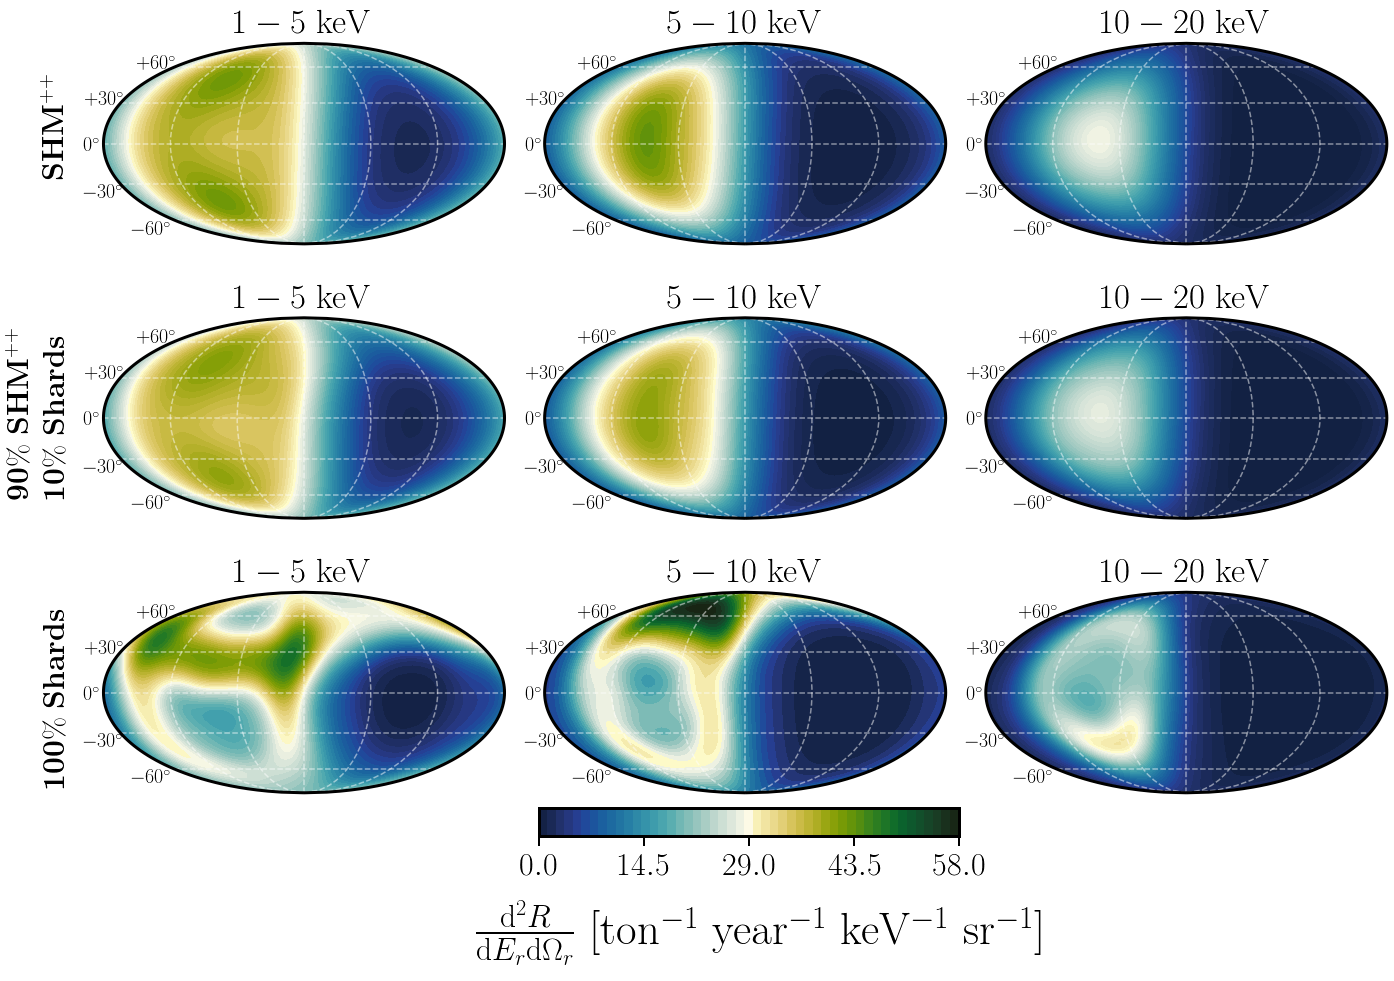

In [19]:
fig, axarr = plt.subplots(3, 3,figsize=(23,15))
gs = gridspec.GridSpec(3, 3)
gs.update(wspace=0.1,hspace=0.03)

cmap = cmocean.cm.delta
tit = [r'$1-5$ keV',r'$5-10$ keV',r'$10-20$ keV']

xi = 0.1
dR2 = (1-xi)*dR_map_smooth_s+xi*dR_map_shards_s

cmin = amin(dR_map_shards_s)
cmax = around(amax(dR_map_shards_s),1)

nlevels = 50
tfs = 20

titfontsize = 35

for ibin in range(0,3): 
    ax = plt.subplot(gs[0,ibin],projection=ccrs.Mollweide())
    MollweideMap1(ax,TH,PH,dR_map_smooth_s[:,:,ibin],cmin,cmax,nlevels,cmap,tfs,gridlinecolor='w')
    plt.title(tit[ibin],fontsize=titfontsize,y=1.03)
    if ibin==0:
        ax.annotate(r'{\bf SHM}$^{++}$', xy=(-0.15, 0.35), xycoords='axes fraction',fontsize=30,rotation=90)

for ibin in range(0,3): 
    ax = plt.subplot(gs[1,ibin],projection=ccrs.Mollweide())
    MollweideMap1(ax,TH,PH,dR2[:,:,ibin],cmin,cmax,nlevels,cmap,tfs,gridlinecolor='w')
    plt.title(tit[ibin],fontsize=titfontsize,y=1.03)
    if ibin==0:
        ax.annotate(r'{\bf 90}\% {\bf SHM}$^{++}$', xy=(-0.24, 0.12), xycoords='axes fraction',fontsize=30,rotation=90)
        ax.annotate(r'{\bf 10}\% {\bf Shards}', xy=(-0.15, 0.12), xycoords='axes fraction',fontsize=30,rotation=90)


for ibin in range(0,3): 
    ax = plt.subplot(gs[2,ibin],projection=ccrs.Mollweide())
    MollweideMap1(ax,TH,PH,dR_map_shards_s[:,:,ibin],cmin,cmax,nlevels,cmap,tfs,gridlinecolor='w')
    plt.title(tit[ibin],fontsize=titfontsize,y=1.03)
    if ibin==0:
        ax.annotate(r'{\bf 100}\% {\bf Shards}', xy=(-0.15, 0.05), xycoords='axes fraction',fontsize=30,rotation=90)


# # Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbaxes = inset_axes(ax, width="60%", height="7%", bbox_to_anchor=[370, -240, 700, 400]) 
norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=linspace(cmin,cmax,5),boundaries=linspace(cmin,cmax,nlevels),orientation='horizontal')
f = plt.gcf().get_children()
cbar = f[3]
plt.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7,labelsize=32)
plt.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False,labelsize=32)
plt.gcf().text(0.35,-0.004,r'$\frac{\mathrm{d}^2 R}{\mathrm{d}E_r \mathrm{d}\Omega_r}$ [ton$^{-1}$ year$^{-1}$ keV$^{-1}$ sr$^{-1}$]',fontsize=45)


# save figure
plt.show()
pltname = 'Shards_Directional'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

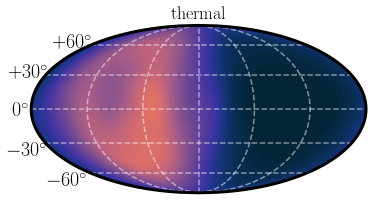

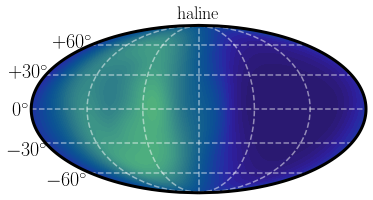

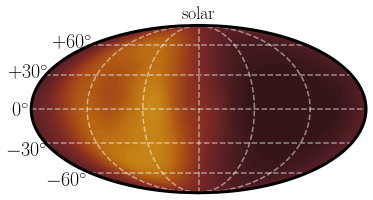

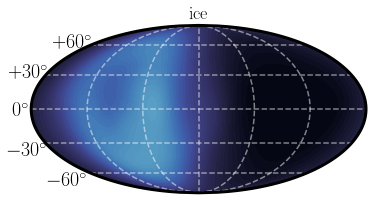

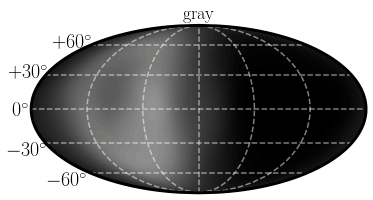

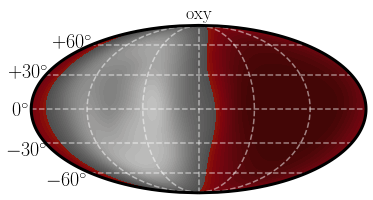

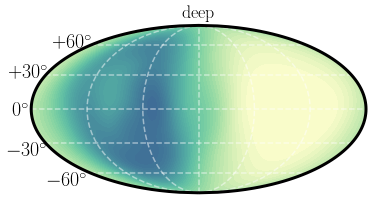

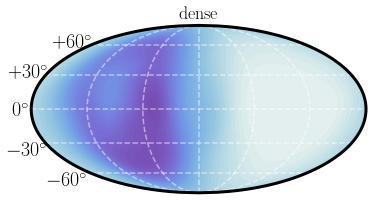

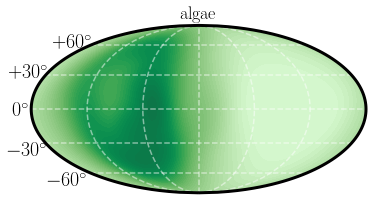

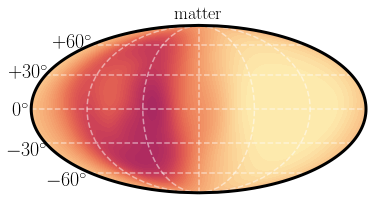

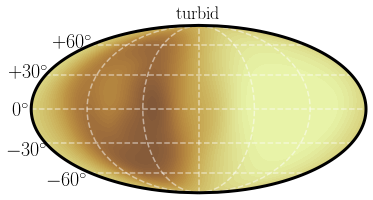

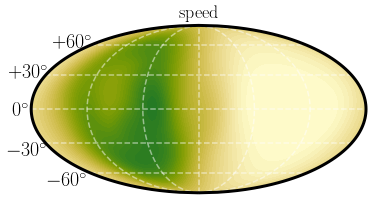

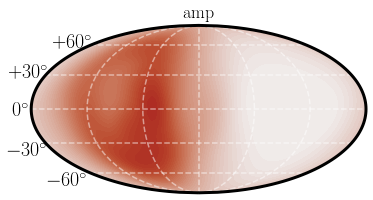

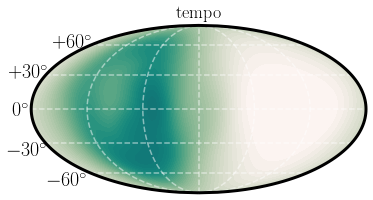

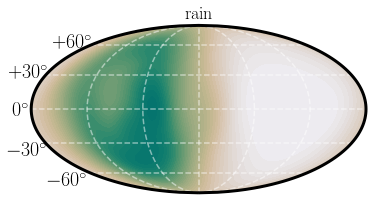

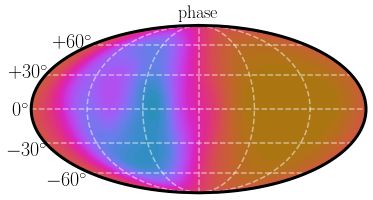

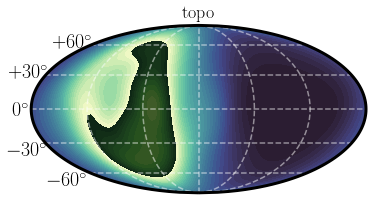

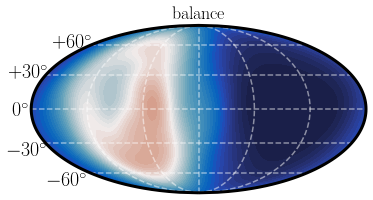

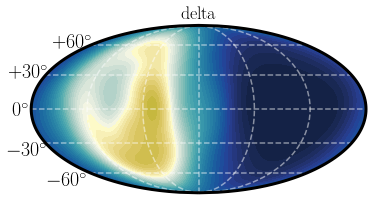

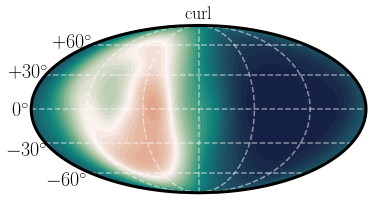

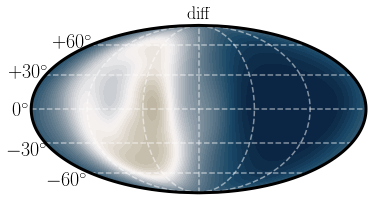

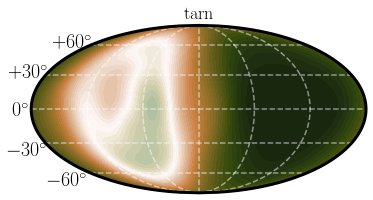

In [111]:
for cmap in cmocean.cm.cmapnames:
    ax = plt.axes(projection=ccrs.Mollweide())
    MollweideMap1(ax,TH,PH,dR_map_shards_s[:,:,ibin],cmin,cmax,nlevels,eval('cmocean.cm.'+cmap),tfs,gridlinecolor='w')
    plt.title(cmap)
    plt.show()

In [118]:
dir(cm)

['Accent',
 'Accent_r',
 'Blues',
 'Blues_r',
 'BrBG',
 'BrBG_r',
 'BuGn',
 'BuGn_r',
 'BuPu',
 'BuPu_r',
 'CMRmap',
 'CMRmap_r',
 'Dark2',
 'Dark2_r',
 'GnBu',
 'GnBu_r',
 'Greens',
 'Greens_r',
 'Greys',
 'Greys_r',
 'LUTSIZE',
 'OrRd',
 'OrRd_r',
 'Oranges',
 'Oranges_r',
 'PRGn',
 'PRGn_r',
 'Paired',
 'Paired_r',
 'Pastel1',
 'Pastel1_r',
 'Pastel2',
 'Pastel2_r',
 'PiYG',
 'PiYG_r',
 'PuBu',
 'PuBuGn',
 'PuBuGn_r',
 'PuBu_r',
 'PuOr',
 'PuOr_r',
 'PuRd',
 'PuRd_r',
 'Purples',
 'Purples_r',
 'RdBu',
 'RdBu_r',
 'RdGy',
 'RdGy_r',
 'RdPu',
 'RdPu_r',
 'RdYlBu',
 'RdYlBu_r',
 'RdYlGn',
 'RdYlGn_r',
 'Reds',
 'Reds_r',
 'ScalarMappable',
 'Set1',
 'Set1_r',
 'Set2',
 'Set2_r',
 'Set3',
 'Set3_r',
 'Spectral',
 'Spectral_r',
 'Wistia',
 'Wistia_r',
 'YlGn',
 'YlGnBu',
 'YlGnBu_r',
 'YlGn_r',
 'YlOrBr',
 'YlOrBr_r',
 'YlOrRd',
 'YlOrRd_r',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_generate_cmap',
 '_reverse_cma

In [21]:
names[argsort(weights)]

53     NCand25
57    NCand28b
23     Cand16b
41     NCand16
32      NCand8
50     NCand23
45    NCand19b
42     NCand17
33     NCand9a
52    NCand24b
51    NCand24a
54     NCand26
28      NCand3
20     Cand15a
21     Cand15b
31      NCand7
30     NCand6b
26     NCand2a
56    NCand28a
43     NCand18
46     NCand20
39    NCand13a
40    NCand13b
24      Cand17
48    NCand21b
58     NCand29
29     NCand6a
44    NCand19a
19     Cand14b
22     Cand16a
9         Rg7b
36    NCand10b
34     NCand9b
18     Cand14a
47    NCand21a
55     NCand27
25      NCand0
38     NCand12
14     Cand11a
37     NCand11
27     NCand2b
49     NCand22
8         Rg7a
11      Cand8b
35    NCand10a
1          S2a
15     Cand11b
3          Rg2
10      Cand8a
16      Cand12
17      Cand13
13      Cand10
12       Cand9
6         Rg6a
4         Rg5a
7         Rg6b
5         Rg5b
2          S2b
0           S1
Name: group_id, dtype: object